# FinGAN Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm, wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import brentq, minimize_scalar

# TCN implementation
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.prelu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.prelu2 = nn.PReLU()
        self.skip_connection = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x):
        residual = self.skip_connection(x)
        out = self.prelu1(self.conv1(x))
        out = self.prelu2(self.conv2(out))
        
        # Handle dimension mismatch
        min_size = min(out.size(2), residual.size(2))
        out = out[:, :, :min_size]
        residual = residual[:, :, :min_size]
        
        return out + residual

class TCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=2, receptive_field_size=127):
        super(TCN, self).__init__()
        layers = []
        
        # First block with kernel size 1
        layers.append(TemporalBlock(input_dim, hidden_dim, kernel_size=1, dilation=1))
        
        # Subsequent blocks with increasing dilation to achieve receptive field of 127
        dilations = [1, 2, 4, 8, 16, 32]
        for d in dilations:
            layers.append(TemporalBlock(hidden_dim, hidden_dim, kernel_size=2, dilation=d))
        
        self.network = nn.Sequential(*layers)
        self.final_conv = nn.Conv1d(hidden_dim, output_dim, 1)
        
    def forward(self, x):
        # Check for NaN or inf values
        if torch.isnan(x).any() or torch.isinf(x).any():
            # Handle corrupted input by replacing NaN/inf with zeros
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            
        # x: [batch_size, seq_len, input_dim]
        x = x.permute(0, 2, 1)  # [batch_size, input_dim, seq_len]
        x = self.network(x)
        x = self.final_conv(x)
        return x.permute(0, 2, 1)  # [batch_size, seq_len, output_dim]

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, receptive_field_size=127):
        super(Encoder, self).__init__()
        self.tcn_volatility = TCN(input_dim, hidden_dim, input_dim, receptive_field_size=receptive_field_size)
        self.tcn_drift = TCN(input_dim, hidden_dim, input_dim, receptive_field_size=receptive_field_size)
        self.tcn_innovation = TCN(input_dim, hidden_dim, input_dim, receptive_field_size=receptive_field_size)
        self.input_dim = input_dim
        
    def forward(self, rt):
        """
        Forward pass of Encoder
        Args:
            rt: Real returns [batch_size, seq_len, input_dim]
        Returns:
            sigma_t: Volatility [batch_size, seq_len, input_dim]
            mu_t: Drift [batch_size, seq_len, input_dim]
            epsilon_t: Innovation [batch_size, seq_len, input_dim]
        """
        # Input validation
        if torch.isnan(rt).any() or torch.isinf(rt).any():
            rt = torch.nan_to_num(rt, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in encoder input were replaced")
            
        # Process through TCNs
        sigma_t = torch.abs(self.tcn_volatility(rt)) + 1e-6  # Ensure strictly positive volatility
        mu_t = self.tcn_drift(rt)
        epsilon_t = self.tcn_innovation(rt)
        
        # Ensure all outputs have the same sequence length
        min_len = min(sigma_t.size(1), mu_t.size(1), epsilon_t.size(1))
        sigma_t = sigma_t[:, :min_len, :]
        mu_t = mu_t[:, :min_len, :]
        epsilon_t = epsilon_t[:, :min_len, :]
        
        return sigma_t, mu_t, epsilon_t

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, receptive_field_size=127):
        super(Decoder, self).__init__()
        self.network = TCN(input_dim, hidden_dim, input_dim, receptive_field_size=receptive_field_size)
        
    def forward(self, r_tilde):
        """
        Forward pass of Decoder
        Args:
            r_tilde: Risk-neutral returns [batch_size, seq_len, input_dim]
        Returns:
            r_hat: Reconstructed real returns [batch_size, seq_len, input_dim]
        """
        # Input validation
        if torch.isnan(r_tilde).any() or torch.isinf(r_tilde).any():
            r_tilde = torch.nan_to_num(r_tilde, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in decoder input were replaced")
            
        return self.network(r_tilde)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim, hidden_dim, receptive_field_size=127):
        super(Generator, self).__init__()
        self.tcn_volatility = TCN(noise_dim, hidden_dim, output_dim, receptive_field_size=receptive_field_size)
        self.tcn_drift = TCN(noise_dim, hidden_dim, output_dim, receptive_field_size=receptive_field_size)
        self.tcn_innovation = TCN(noise_dim, hidden_dim, output_dim, receptive_field_size=receptive_field_size)
        self.output_dim = output_dim
        self.noise_dim = noise_dim
        self.receptive_field_size = receptive_field_size
        
    def forward(self, z_t):
        """
        Forward pass of Generator
        Args:
            z_t: Noise input [batch_size, seq_len, noise_dim]
        Returns:
            r_tilde_hat: Generated risk-neutral returns
            sigma_hat: Generated volatility
            mu_hat: Generated drift
            epsilon_hat: Generated innovation
        """
        # Input validation
        if torch.isnan(z_t).any() or torch.isinf(z_t).any():
            z_t = torch.nan_to_num(z_t, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in generator input were replaced")
            
        # Process through TCNs
        sigma_hat = torch.abs(self.tcn_volatility(z_t)) + 1e-6  # Ensure strictly positive volatility
        mu_hat = self.tcn_drift(z_t)
        epsilon_hat = self.tcn_innovation(z_t)
        
        # Ensure all outputs have the same sequence length
        min_len = min(sigma_hat.size(1), mu_hat.size(1), epsilon_hat.size(1))
        sigma_hat = sigma_hat[:, :min_len, :]
        mu_hat = mu_hat[:, :min_len, :]
        epsilon_hat = epsilon_hat[:, :min_len, :]
        
        # Compute synthetic risk-neutral return
        r_tilde_hat = sigma_hat * epsilon_hat + mu_hat
        
        return r_tilde_hat, sigma_hat, mu_hat, epsilon_hat
    
    def transform_to_risk_neutral(self, sigma_hat, epsilon_hat, rf_rate):
        """
        Convert to risk-neutral measure using the risk-free rate.
        """
        return sigma_hat * epsilon_hat - 0.5 * sigma_hat**2 + rf_rate

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, receptive_field_size=127):
        super(Discriminator, self).__init__()
        self.tcn = TCN(input_dim, hidden_dim, hidden_dim, receptive_field_size=receptive_field_size)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        Forward pass of Discriminator
        Args:
            x: Input sequence [batch_size, seq_len, input_dim]
        Returns:
            Classification probability [batch_size, 1]
        """
        # Input validation
        if torch.isnan(x).any() or torch.isinf(x).any():
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in discriminator input were replaced")
            
        features = self.tcn(x)
        # Global average pooling to handle variable sequence lengths
        pooled = torch.mean(features, dim=1)
        output = self.fc(pooled)
        return self.sigmoid(output)

# Original RiNNGenerator implementation
class RiNNGenerator(nn.Module):
    def __init__(self, noise_dim, output_dim, hidden_dim, receptive_field_size=127):
        super(RiNNGenerator, self).__init__()
        self.gh = TCN(noise_dim, hidden_dim, 2*output_dim, receptive_field_size)  # Volatility and drift
        self.geps = TCN(noise_dim, hidden_dim, output_dim, receptive_field_size)  # Innovation
        self.output_dim = output_dim
        self.noise_dim = noise_dim
        self.receptive_field_size = receptive_field_size

    def forward(self, z_t):
        """
        Forward pass of Generator:
        - Takes noise `z_t` as input.
        - Generates synthetic volatility `sigma_hat`, drift `mu_hat`, and innovation `epsilon_hat`.
        - Returns synthetic risk-neutral representation `r_tilde_hat`.
        """
        batch_size, seq_len, _ = z_t.shape

        # Process input validation
        if torch.isnan(z_t).any() or torch.isinf(z_t).any():
            z_t = torch.nan_to_num(z_t, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in RiNNGenerator input were replaced")

        # Generate historical noise for temporal modeling
        z_history = torch.randn(batch_size, self.receptive_field_size, self.noise_dim, device=z_t.device)

        # Generate synthetic volatility and drift
        h_hat = self.gh(z_history)
        sigma_hat = torch.abs(h_hat[:, :, :self.output_dim]) + 1e-6  # Ensure strictly positive volatility
        mu_hat = h_hat[:, :, self.output_dim:(2*self.output_dim)]
        
        # Generate synthetic innovation
        epsilon_hat = self.geps(z_t)

        # Ensure all tensors have the same sequence length
        min_seq_len = min(sigma_hat.size(1), epsilon_hat.size(1), seq_len)
        sigma_hat = sigma_hat[:, :min_seq_len, :]
        mu_hat = mu_hat[:, :min_seq_len, :]
        epsilon_hat = epsilon_hat[:, :min_seq_len, :]

        # Compute synthetic risk-neutral return
        r_tilde_hat = sigma_hat * epsilon_hat + mu_hat

        return r_tilde_hat, sigma_hat, mu_hat, epsilon_hat

    def transform_to_risk_neutral(self, sigma_hat, epsilon_hat, rf_rate):
        """
        Convert to risk-neutral measure using the risk-free rate.
        """
        return sigma_hat * epsilon_hat - 0.5 * sigma_hat**2 + rf_rate

class FinGAN:
    def __init__(self, input_dim=1, hidden_dim=80, noise_dim=10, rf_rate=0.03, receptive_field_size=127, device=None):
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.noise_dim = noise_dim
        self.rf_rate = rf_rate  # Risk-free rate
        self.receptive_field_size = receptive_field_size
        
        # Initialize networks
        self.encoder = Encoder(input_dim, hidden_dim, receptive_field_size).to(self.device)
        self.decoder = Decoder(input_dim, hidden_dim, receptive_field_size).to(self.device)
        self.generator = Generator(noise_dim, input_dim, hidden_dim, receptive_field_size).to(self.device)
        self.discriminator = Discriminator(input_dim, hidden_dim, receptive_field_size).to(self.device)

        # Initialize optimizers with lower learning rates for stability
        self.encoder_decoder_optimizer = optim.Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=1e-4, betas=(0.5, 0.999)
        )
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

        # Loss functions
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

        # Hyperparameters for loss weighting
        self.epsilon = 0.1  # ε in paper
        self.gamma = 0.1    # γ in paper
        self.lambda_kl = 0.05  # Weight for KL divergence loss
        
        # For gradient clipping
        self.clip_value = 1.0
        
        # For tracking training progress
        self.current_epoch = 0
        
    def train_step(self, real_returns):
        """
        Single training step for FinGAN with all three losses from the paper
        
        Args:
            real_returns: Real stock log returns [batch_size, seq_len, input_dim]
            
        Returns:
            Dictionary of loss values
        """
        # Input validation
        if torch.isnan(real_returns).any() or torch.isinf(real_returns).any():
            real_returns = torch.nan_to_num(real_returns, nan=0.0, posinf=0.0, neginf=0.0)
            print("Warning: NaN or inf values in training data were replaced")
        
        batch_size, seq_len, _ = real_returns.shape
        
        # Generate noise for the generator - use a fixed seed for reproducibility in training
        torch.manual_seed(42 + self.current_epoch)
        z_t = torch.randn(batch_size, seq_len, self.noise_dim, device=self.device)
        
        # === STEP 1: Process data through encoder ===
        self.encoder_decoder_optimizer.zero_grad()
        
        # Extract volatility, drift, and innovation terms from real returns
        sigma_t, mu_t, epsilon_t = self.encoder(real_returns)
        
        # Construct risk-neutral returns
        r_tilde = sigma_t * epsilon_t + mu_t
        
        # Pass through decoder to reconstruct original returns
        r_hat = self.decoder(r_tilde)
        
        # Ensure r_hat and real_returns have the same shape for loss calculation
        min_len = min(r_hat.shape[1], real_returns.shape[1])
        r_hat = r_hat[:, :min_len, :]
        real_returns_trimmed = real_returns[:, :min_len, :]
        
        # Reconstruction loss (LR in paper)
        reconstruction_loss = self.mse_loss(r_hat, real_returns_trimmed)
        
        # === STEP 2: Generate synthetic data ===
        r_tilde_hat, sigma_hat, mu_hat, epsilon_hat = self.generator(z_t)
        
        # Ensure consistent dimensions for volatility and innovation terms
        min_len = min(sigma_t.shape[1], epsilon_t.shape[1], sigma_hat.shape[1], epsilon_hat.shape[1])
        sigma_t = sigma_t[:, :min_len, :]
        epsilon_t = epsilon_t[:, :min_len, :]
        sigma_hat = sigma_hat[:, :min_len, :]
        epsilon_hat = epsilon_hat[:, :min_len, :]
        
        # === STEP 3: Train discriminator ===
        self.discriminator_optimizer.zero_grad()
        
        # Create real and fake labels with label smoothing for GAN stability
        real_labels = torch.ones(batch_size, 1, device=self.device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(batch_size, 1, device=self.device) + 0.1  # Label smoothing
        
        # Adjust r_tilde and r_tilde_hat to same length
        min_len = min(r_tilde.shape[1], r_tilde_hat.shape[1])
        r_tilde_disc = r_tilde[:, :min_len, :]
        r_tilde_hat_disc = r_tilde_hat[:, :min_len, :]
        
        # Discriminator predictions
        d_real = self.discriminator(r_tilde_disc.detach())
        d_fake = self.discriminator(r_tilde_hat_disc.detach())
        
        # Discriminator losses (LD in paper)
        d_real_loss = self.bce_loss(d_real, real_labels)
        d_fake_loss = self.bce_loss(d_fake, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        
        # Check for NaN in discriminator loss
        if torch.isnan(d_loss).any() or torch.isinf(d_loss).any():
            print("Warning: NaN or inf in discriminator loss. Using fallback loss.")
            d_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        else:
            d_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), self.clip_value)
            self.discriminator_optimizer.step()
        
        # === STEP 4: Train encoder-decoder ===
        # Prepare distributions for KL divergence - handle numerical stability
        real_returns_log = torch.log(torch.abs(real_returns_trimmed) + 1e-8)
        r_hat_log = torch.log(torch.abs(r_hat) + 1e-8)
        
        try:
            # Calculate KL divergence between real and reconstructed returns
            kl_loss = self.kl_loss(
                F.log_softmax(r_hat_log.reshape(-1, r_hat_log.size(-1)), dim=-1),
                F.softmax(real_returns_log.reshape(-1, real_returns_log.size(-1)), dim=-1)
            )
            
            # Check for NaN in KL loss
            if torch.isnan(kl_loss).any() or torch.isinf(kl_loss).any():
                print("Warning: NaN or inf in KL loss. Using fallback value.")
                kl_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        except Exception as e:
            print(f"Error in KL calculation: {e}. Using fallback value.")
            kl_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        
        # Distribution matching loss 
        supervised_loss = self.mse_loss(
            sigma_t * epsilon_t,
            sigma_hat.detach() * epsilon_hat.detach()
        )
        
        # Combined encoder-decoder loss (LR + LS in paper)
        encoder_decoder_loss = reconstruction_loss + self.epsilon * supervised_loss + self.lambda_kl * kl_loss
        
        # Check for NaN in encoder-decoder loss
        if torch.isnan(encoder_decoder_loss).any() or torch.isinf(encoder_decoder_loss).any():
            print("Warning: NaN or inf in encoder-decoder loss. Using fallback loss.")
            encoder_decoder_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        else:
            encoder_decoder_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), self.clip_value)
            torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), self.clip_value)
            self.encoder_decoder_optimizer.step()
        
        # === STEP 5: Train generator ===
        self.generator_optimizer.zero_grad()
        
        # Regenerate discriminator output for the generator
        d_fake_gen = self.discriminator(r_tilde_hat_disc)
        
        # Generator adversarial loss (LG in paper)
        g_loss_adv = self.bce_loss(d_fake_gen, real_labels)
        
        # Generator supervised loss (another component of LG)
        g_loss_sup = self.mse_loss(
            sigma_t.detach() * epsilon_t.detach(),
            sigma_hat * epsilon_hat
        )
        
        # Additional KL divergence for generator - FIXED VERSION
        try:
            # Compute means and standard deviations with robust handling
            real_vol_innov = sigma_t.detach() * epsilon_t.detach()
            gen_vol_innov = sigma_hat * epsilon_hat
            
            # Compute statistics along time dimension (dimension 1)
            # This fixes the issue with batch size 1
            real_mean = torch.mean(real_vol_innov, dim=1, keepdim=True)
            gen_mean = torch.mean(gen_vol_innov, dim=1, keepdim=True)
            
            # Use a robust std calculation with minimum value to prevent NaN/zero std
            real_std = torch.std(real_vol_innov, dim=1, keepdim=True).clamp(min=1e-6)
            gen_std = torch.std(gen_vol_innov, dim=1, keepdim=True).clamp(min=1e-6)
            
            # Create normal distributions with the computed parameters
            real_dist = torch.distributions.Normal(real_mean, real_std)
            gen_dist = torch.distributions.Normal(gen_mean, gen_std)
            
            # Calculate KL divergence - use a safer approach
            try:
                # Try the torch distribution KL first
                dist_kl_loss = torch.distributions.kl_divergence(real_dist, gen_dist).mean()
                
                # If KL is too large or NaN, use fallback
                if torch.isnan(dist_kl_loss) or torch.isinf(dist_kl_loss) or dist_kl_loss > 100:
                    print("KL divergence too large, using MSE as fallback")
                    dist_kl_loss = self.mse_loss(real_mean, gen_mean) + self.mse_loss(real_std, gen_std)
            except Exception as e:
                print(f"Error in KL calculation: {e}, using MSE fallback")
                dist_kl_loss = self.mse_loss(real_mean, gen_mean) + self.mse_loss(real_std, gen_std)
                
        except Exception as e:
            print(f"Error in distribution comparison: {e}. Using fallback value.")
            dist_kl_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        
        # Combined generator loss (LG in paper)
        g_loss = g_loss_adv + self.gamma * g_loss_sup + self.lambda_kl * dist_kl_loss
        
        # Check for NaN in generator loss
        if torch.isnan(g_loss).any() or torch.isinf(g_loss).any():
            print("Warning: NaN or inf in generator loss. Using fallback loss.")
            g_loss = torch.tensor(0.1, device=self.device, requires_grad=True)
        else:
            g_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), self.clip_value)
            self.generator_optimizer.step()
        
        return {
            'reconstruction_loss': reconstruction_loss.item(),
            'discriminator_loss': d_loss.item(),
            'generator_loss': g_loss.item(),
            'supervised_loss': supervised_loss.item(),
            'kl_loss': kl_loss.item(),
            'dist_kl_loss': dist_kl_loss.item()
        }
    
    def generate_risk_neutral_returns(self, seq_len, batch_size=1, rf_rate=None):
        """
        Generate risk-neutral return components for option pricing
        
        Args:
            seq_len: Number of time steps
            batch_size: Number of sample paths
            rf_rate: Risk-free rate (uses self.rf_rate if None)
            
        Returns:
            sigma_hat: Generated volatility
            epsilon_hat: Generated innovations
            risk_neutral_returns: Complete risk-neutral returns
        """
        if rf_rate is None:
            rf_rate = self.rf_rate
            
        with torch.no_grad():
            # Generate noise
            z_t = torch.randn(batch_size, seq_len, self.noise_dim, device=self.device)
            
            # Generate synthetic data
            _, sigma_hat, _, epsilon_hat = self.generator(z_t)
            
            # Calculate risk-neutral drift term (equation 20 from paper)
            risk_neutral_drift = rf_rate - 0.5 * torch.square(sigma_hat)
            
            # Calculate complete risk-neutral returns
            dt = 1/252  # Daily time step
            risk_neutral_returns = risk_neutral_drift * dt + sigma_hat * epsilon_hat * np.sqrt(dt)
            
            return sigma_hat.cpu().numpy(), epsilon_hat.cpu().numpy(), risk_neutral_returns.cpu().numpy()
    
    def price_european_option(self, S0, K, T, r, option_type='call', n_paths=10000, dt=1/252):
        """
        Price European options using Monte Carlo with FinGAN-generated risk-neutral paths
        
        Using Equation 20 from the reference paper for risk-neutral dynamics
        
        Args:
            S0: Initial stock price
            K: Strike price
            T: Time to maturity in years
            r: Risk-free rate
            option_type: 'call' or 'put'
            n_paths: Number of Monte Carlo paths
            dt: Time step size (1/252 for daily)
            
        Returns:
            Option price
        """
        n_steps = int(T / dt)
        batch_size = 100  # Process in batches to avoid memory issues
        n_batches = n_paths // batch_size
        
        all_payoffs = []
        
        try:
            with torch.no_grad():
                for _ in range(n_batches):
                    # Generate noise
                    z_t = torch.randn(batch_size, n_steps, self.noise_dim, device=self.device)
                    
                    # Generate synthetic data using the generator
                    _, sigma_hat, _, epsilon_hat = self.generator(z_t)
                    
                    # Calculate risk-neutral log returns according to Equation 20:
                    # dX_t = (r - 0.5*σ²)dt + σdW_t
                    # Where σdW_t is represented by σ_hat * ε_hat
                    risk_neutral_drift = r - 0.5 * torch.square(sigma_hat)
                    risk_neutral_returns = (risk_neutral_drift * dt + sigma_hat * epsilon_hat * np.sqrt(dt)).cpu().numpy()
                    
                    # Check for NaN values in returns
                    if np.isnan(risk_neutral_returns).any() or np.isinf(risk_neutral_returns).any():
                        risk_neutral_returns = np.nan_to_num(risk_neutral_returns, nan=0.0, posinf=0.0, neginf=0.0)
                        print("Warning: NaN or inf values in risk-neutral returns were replaced")
                    
                    # Generate price paths
                    paths = np.zeros((batch_size, n_steps + 1))
                    paths[:, 0] = S0
                    
                    for t in range(1, n_steps + 1):
                        if t-1 < risk_neutral_returns.shape[1]:
                            # Using the log return directly with exp()
                            returns = risk_neutral_returns[:, t-1, 0]
                            # Clip extreme returns for stability
                            returns = np.clip(returns, -0.5, 0.5)
                            paths[:, t] = paths[:, t-1] * np.exp(returns)
                        else:
                            # For longer maturities, resample
                            resample_z = torch.randn(batch_size, 1, self.noise_dim, device=self.device)
                            _, resample_sigma, _, resample_epsilon = self.generator(resample_z)
                            
                            # Calculate risk-neutral increment for resampled data
                            resample_drift = r - 0.5 * torch.square(resample_sigma)
                            resample_returns = (resample_drift * dt + resample_sigma * resample_epsilon * np.sqrt(dt)).cpu().numpy()
                            
                            # Clip extreme returns for stability
                            resample_returns = np.clip(resample_returns, -0.5, 0.5)
                            paths[:, t] = paths[:, t-1] * np.exp(resample_returns[:, 0, 0])
                    
                    # Calculate payoffs
                    if option_type.lower() == 'call':
                        payoffs = np.maximum(paths[:, -1] - K, 0)
                    else:  # put
                        payoffs = np.maximum(K - paths[:, -1], 0)
                        
                    all_payoffs.append(payoffs)
            
            # Combine all batches of payoffs
            all_payoffs = np.concatenate(all_payoffs)
            
            # Remove any extreme values that might have slipped through
            all_payoffs = np.clip(all_payoffs, 0, 10*S0)  # Reasonable limit for payoffs
            
            # Discount payoffs to present value
            option_price = np.mean(all_payoffs) * np.exp(-r * T)
            
            return option_price
        
        except Exception as e:
            print(f"Error in option pricing: {e}")
            # Fallback to Black-Scholes as a reasonable approximation
            print("Using Black-Scholes as fallback")
            
            # Estimate volatility from a sample of generated returns
            try:
                _, _, sample_returns = self.generate_risk_neutral_returns(100, batch_size=100, rf_rate=r)
                sigma_estimate = np.std(sample_returns) * np.sqrt(252)  # Annualize
                return black_scholes_call(S0, K, T, r, sigma_estimate)
            except:
                # Ultimate fallback: use a reasonable volatility
                print("Using fixed volatility as ultimate fallback")
                return black_scholes_call(S0, K, T, r, 0.2)
    
    def generate_implied_volatility_surface(self, S0, r, maturities, moneyness_levels):
        """
        Generate implied volatility surface
        
        Args:
            S0: Current stock price
            r: Risk-free rate
            maturities: List of maturities in years
            moneyness_levels: List of moneyness levels (K/S0)
            
        Returns:
            2D array of implied volatilities
        """
        iv_surface = np.zeros((len(maturities), len(moneyness_levels)))
        
        # Generate surface with retry mechanism for failed points
        for i, T in enumerate(maturities):
            for j, m in enumerate(moneyness_levels):
                K = S0 * m
                
                try:
                    # Price the option
                    option_price = self.price_european_option(S0, K, T, r, 'call')
                    
                    # Calculate implied volatility
                    iv = calculate_implied_volatility(option_price, S0, K, T, r)
                    
                    # Validate the implied volatility value
                    if np.isnan(iv) or iv < 0.001 or iv > 2.0:
                        # Try with more paths
                        option_price = self.price_european_option(S0, K, T, r, 'call', n_paths=20000)
                        iv = calculate_implied_volatility(option_price, S0, K, T, r)
                    
                    iv_surface[i, j] = iv if not np.isnan(iv) and 0.001 <= iv <= 2.0 else 0.2
                
                except Exception as e:
                    print(f"Error calculating IV for T={T}, K/S0={m}: {e}")
                    # Use a reasonable fallback value
                    iv_surface[i, j] = 0.2
        
        # Smooth the surface by replacing extreme outliers with local averages
        for i in range(len(maturities)):
            for j in range(len(moneyness_levels)):
                if iv_surface[i, j] < 0.05 or iv_surface[i, j] > 1.0:
                    # Find valid neighbors
                    neighbors = []
                    for ni in range(max(0, i-1), min(len(maturities), i+2)):
                        for nj in range(max(0, j-1), min(len(moneyness_levels), j+2)):
                            if (ni != i or nj != j) and 0.05 <= iv_surface[ni, nj] <= 1.0:
                                neighbors.append(iv_surface[ni, nj])
                    
                    # Replace with average of valid neighbors if any exist
                    if neighbors:
                        iv_surface[i, j] = np.mean(neighbors)
        
        return iv_surface

# Helper functions
def black_scholes_call(S, K, T, r, sigma):
    """Calculate Black-Scholes call option price"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def calculate_implied_volatility(option_price, S0, K, T, r, option_type='call'):
    """
    Calculate implied volatility using improved accuracy method
    """
    def objective(sigma):
        # Modified objective function to improve accuracy
        model_price = black_scholes_call(S0, K, T, r, sigma)
        return abs((model_price - option_price) / option_price)  # Relative error

    try:
        # Use scipy's minimize for better accuracy
        result = minimize_scalar(objective, bounds=(0.001, 2.0), method='bounded')
        return result.x
    except:
        # Fallback to brentq if minimize fails
        try:
            def original_objective(sigma):
                return black_scholes_call(S0, K, T, r, sigma) - option_price
                
            return brentq(original_objective, 0.001, 2.0)
        except:
            # Return a reasonable default value if all methods fail
            return 0.2

def prepare_option_data_for_fingan(stock_data, input_dim=1, max_seq_len=127):
    """
    Prepare stock price data for FinGAN training by computing log returns
    
    Args:
        stock_data: DataFrame containing stock price data
        input_dim: Number of assets/features
        max_seq_len: Maximum sequence length
        
    Returns:
        Array of log returns with shape [1, seq_len, input_dim]
    """
    try:
        # Sort by date
        stock_data = stock_data.sort_values('Date')
        
        # Extract stock prices
        prices = stock_data['Stock Price'].values
        
        # Check for non-positive prices
        if np.any(prices <= 0):
            print("Warning: Non-positive prices found. Replacing with small positive values.")
            prices = np.maximum(prices, 0.01)  # Replace non-positive values
        
        # Calculate log returns
        returns = np.diff(np.log(prices))
        
        # Check for NaN or inf values
        if np.isnan(returns).any() or np.isinf(returns).any():
            print("Warning: NaN or inf values in returns. Replacing with zeros.")
            returns = np.nan_to_num(returns, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Limit sequence length to max_seq_len
        if len(returns) > max_seq_len:
            returns = returns[-max_seq_len:]  # Use the most recent returns
        
        # Reshape for FinGAN input [batch_size, seq_len, input_dim]
        returns = returns.reshape(-1, 1)  # [seq_len, input_dim]
        returns = returns[np.newaxis, :, :]  # [1, seq_len, input_dim]
        
        return returns
    
    except Exception as e:
        print(f"Error in prepare_option_data_for_fingan: {e}")
        # Return a dummy array of zeros as fallback
        dummy_returns = np.zeros((1, min(max_seq_len, 30), input_dim))
        print(f"Returning dummy array with shape {dummy_returns.shape}")
        return dummy_returns

def train_fingan(fingan, train_data, epochs=100, batch_size=32):
    """
    Train the FinGAN model
    
    Args:
        fingan: FinGAN model
        train_data: Training data tensor of stock returns [n_samples, seq_len, 1]
        epochs: Number of training epochs
        batch_size: Batch size
    
    Returns:
        Loss history
    """
    # Initial batch size check
    if train_data.shape[0] < batch_size:
        print(f"Warning: Training data batch size ({train_data.shape[0]}) smaller than requested batch size ({batch_size})")
        print(f"Setting batch size to {train_data.shape[0]}")
        batch_size = train_data.shape[0]
    
    # Ensure the data has proper shape for training
    if len(train_data.shape) != 3:
        print(f"Warning: Expected 3D tensor [batch, seq_len, features], got shape {train_data.shape}")
        if len(train_data.shape) == 2:
            print("Adding batch dimension")
            train_data = train_data.unsqueeze(0)
    
    loss_history = {
        'reconstruction_loss': [],
        'discriminator_loss': [],
        'generator_loss': [],
        'supervised_loss': [],
        'kl_loss': [],
        'dist_kl_loss': []
    }
    
    # Input validation
    if torch.isnan(train_data).any() or torch.isinf(train_data).any():
        print("Warning: NaN or inf values in training data. Replacing with zeros.")
        train_data = torch.nan_to_num(train_data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(train_data)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Learning rate scheduling for training stability
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        fingan.generator_optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        fingan.discriminator_optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    enc_dec_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        fingan.encoder_decoder_optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    
    try:
        for epoch in range(epochs):
            fingan.current_epoch = epoch  # Update current epoch for train_step
            epoch_losses = {k: [] for k in loss_history.keys()}
            
            for batch in dataloader:
                returns = batch[0].to(fingan.device)
                
                # Train step with error handling
                try:
                    losses = fingan.train_step(returns)
                    
                    # Record losses
                    for k, v in losses.items():
                        if k in epoch_losses:
                            epoch_losses[k].append(v)
                
                except Exception as e:
                    print(f"Error in training batch: {e}")
                    # Continue with next batch
                    continue
            
            # Average losses for the epoch
            avg_losses = {}
            for k, v in epoch_losses.items():
                if v:  # Only compute average if there are values
                    avg_loss = sum(v) / len(v)
                    loss_history[k].append(avg_loss)
                    avg_losses[k] = avg_loss
                else:
                    loss_history[k].append(float('nan'))
                    avg_losses[k] = float('nan')
            
            # Update learning rate schedulers
            if 'generator_loss' in avg_losses and not np.isnan(avg_losses['generator_loss']):
                gen_scheduler.step(avg_losses['generator_loss'])
            if 'discriminator_loss' in avg_losses and not np.isnan(avg_losses['discriminator_loss']):
                disc_scheduler.step(avg_losses['discriminator_loss'])
            if 'reconstruction_loss' in avg_losses and not np.isnan(avg_losses['reconstruction_loss']):
                enc_dec_scheduler.step(avg_losses['reconstruction_loss'])
            
            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch + 1}/{epochs}]")
                for k, v in avg_losses.items():
                    if not np.isnan(v):  # Only print if there are valid values
                        print(f"  {k}: {v:.4f}")
        
        return loss_history
    
    except Exception as e:
        print(f"Training interrupted due to error: {e}")
        return loss_history

# Generate stock prices
def simulate_stock_prices(S0, mu, sigma, days):
    dt = 1 / 252
    prices = [S0]
    for _ in range(days - 1):
        rand = np.random.normal(0, 1)
        new_price = prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand)
        prices.append(new_price)
    return prices



# Preparing the data

In [2]:
import os
import pandas as pd

# Define the folder path
data_folder = r"C:\Users\HANS\vscode\projects\study\capstone\capstone_code\data"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(data_folder) if f.lower().endswith('.csv')][:-1]

# Initialize lists to hold matched files
files_2018_2019 = []
files_2019_2020 = []

# Iterate over all files in the folder
for f in os.listdir(data_folder):
    if f.lower().endswith(".csv"):
        name_lower = f.lower()
        if "2018" in name_lower or "2019" in name_lower:
            files_2018_2019.append(f)
        if "2019" in name_lower or "2020" in name_lower:
            files_2019_2020.append(f)

# Clear out the 2018 final CSV file
files_2018_2019 = files_2018_2019[:-1]

# Combine all the CSV files into a single DataFrame
combined_data = pd.DataFrame()
for file in files_2018_2019:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    combined_data = pd.concat([combined_data, df], ignore_index=True)
    
# Sort the combined data according to the date and strike price
combined_data.sort_values(by=["date", "strike_price"], inplace=True)

# Remove unnecessary columns
unnecessary_columns = ["secid", "symbol", "symbol_flag", "last_date", "volume", "open_interest", "delta", "gamma", "vega", 
                       "theta", "cfadj", "am_settlement", "contract_size", "ss_flag", "forward_price", 
                       "expiry_indicator", "suffix", "root", "cusip", "ticker", "sic", "index_flag", 
                       "exchange_d", "class", "issue_type", "industry_group", "issuer", "div_convention", 
                       "am_set_flag", "exercise_style"]
combined_data.drop(columns=unnecessary_columns, inplace=True, errors='ignore')

# Remove if the implied volatility is empty
combined_data.dropna(subset=["impl_volatility"], inplace=True)
combined_data.reset_index(drop=True, inplace=True)

combined_data_call = combined_data[combined_data["cp_flag"] == "C"]
combined_data_call.reset_index(drop=True, inplace=True)


In [3]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar

import warnings
warnings.filterwarnings("ignore")

# Convert date columns to datetime if needed
combined_data_call["date"] = pd.to_datetime(combined_data_call["date"])
combined_data_call["exdate"] = pd.to_datetime(combined_data_call["exdate"])

# Convert to np.datetime64
start_dates = combined_data_call["date"].values.astype("datetime64[D]")
end_dates = combined_data_call["exdate"].values.astype("datetime64[D]")

# Get US federal holidays (as datetime64[D])
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=start_dates.min(), end=end_dates.max()).to_numpy(dtype='datetime64[D]')

# Use numpy.busday_count to count valid trading days
# Add +1 to include the expiration day if needed
combined_data_call["TTM (trading days)"] = np.busday_count(
    start_dates, end_dates + 1, holidays=holidays
)
# Ensure 'date' and 'exdate' columns are datetime objects
combined_data_call["date"] = pd.to_datetime(combined_data_call["date"])
combined_data_call["exdate"] = pd.to_datetime(combined_data_call["exdate"])

# Compute time to maturity in calendar days
combined_data_call["TTM (days)"] = (combined_data_call["exdate"] - combined_data_call["date"]).dt.days

combined_data_call

,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,optionid,TTM (trading days),TTM (days)
0,2018-01-02,2020-12-18,C,700000,1900.50,1909.80,0.255868,118538806,746,1081
1,2018-01-02,2020-12-18,C,750000,1854.50,1864.00,0.293682,118538807,746,1081
2,2018-01-02,2020-12-18,C,800000,1808.70,1818.30,0.303360,118538808,746,1081
3,2018-01-02,2020-12-18,C,850000,1762.90,1772.70,0.305415,118538809,746,1081
4,2018-01-02,2020-12-18,C,900000,1717.30,1727.30,0.305551,118538810,746,1081
...,...,...,...,...,...,...,...,...,...,...
2773065,2019-12-31,2021-03-19,C,4600000,0.75,1.25,0.127527,131694750,306,444
2773066,2019-12-31,2021-06-18,C,4600000,1.55,2.10,0.124949,131694754,369,535
2773067,2019-12-31,2021-12-17,C,4600000,4.60,5.00,0.123632,131694758,494,717
2773068,2019-12-31,2022-12-16,C,4600000,13.00,21.90,0.126980,131820333,743,1081


# Risk Free Rate Data

In [4]:
file_names = [
    r"data/DGS6MO.xlsx", # 6 months data
    r"data/DGS1.xlsx", # 1 year data
    r"data/DGS1MO.xlsx", # 1 month data
    r"data/DGS3MO.xlsx", # 3 months data
    r"data/DGS2.xlsx", # 2 years data
    r"data/DGS3.xlsx" # 3 years data
]

# Read the data from each file and store in a dictionary
rf_data_1m = pd.read_excel(file_names[2], sheet_name="Daily")
rf_data_3m = pd.read_excel(file_names[3], sheet_name="Daily")
rf_data_6m = pd.read_excel(file_names[0], sheet_name="Daily")
rf_data_1y = pd.read_excel(file_names[1], sheet_name="Daily")
rf_data_2y = pd.read_excel(file_names[4], sheet_name="Daily")
rf_data_3y = pd.read_excel(file_names[5], sheet_name="Daily")

# Convert the date columns to datetime format
rf_data_1m["observation_date"] = pd.to_datetime(rf_data_1m["observation_date"])
rf_data_3m["observation_date"] = pd.to_datetime(rf_data_3m["observation_date"])
rf_data_6m["observation_date"] = pd.to_datetime(rf_data_6m["observation_date"])
rf_data_1y["observation_date"] = pd.to_datetime(rf_data_1y["observation_date"])
rf_data_2y["observation_date"] = pd.to_datetime(rf_data_2y["observation_date"])
rf_data_3y["observation_date"] = pd.to_datetime(rf_data_3y["observation_date"])

# Set 'observation_date' as index and convert to dictionary using the DGS1MO column
rf_data_1m = rf_data_1m.set_index("observation_date")["DGS1MO"].to_dict()
rf_data_3m = rf_data_3m.set_index("observation_date")["DGS3MO"].to_dict()
rf_data_6m = rf_data_6m.set_index("observation_date")["DGS6MO"].to_dict()
rf_data_1y = rf_data_1y.set_index("observation_date")["DGS1"].to_dict()
rf_data_2y = rf_data_2y.set_index("observation_date")["DGS2"].to_dict()
rf_data_3y = rf_data_3y.set_index("observation_date")["DGS3"].to_dict()

# Clean the risk rate data
# Using ffill
rf_data_1m = pd.Series(rf_data_1m).ffill().to_dict()
rf_data_3m = pd.Series(rf_data_3m).ffill().to_dict()
rf_data_6m = pd.Series(rf_data_6m).ffill().to_dict()
rf_data_1y = pd.Series(rf_data_1y).ffill().to_dict()
rf_data_2y = pd.Series(rf_data_2y).ffill().to_dict()
rf_data_3y = pd.Series(rf_data_3y).ffill().to_dict()

# Fix the strike price
combined_data_call["strike_price"] = combined_data_call["strike_price"] / 1000

# Insert the risk free rate (still need to fix)
# Map the risk free rate data to the DataFrame
combined_data_call["risk_free_rate_1m"] = combined_data_call["date"].map(rf_data_1m)
combined_data_call



,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,optionid,TTM (trading days),TTM (days),risk_free_rate_1m
0,2018-01-02,2020-12-18,C,700.0,1900.50,1909.80,0.255868,118538806,746,1081,1.29
1,2018-01-02,2020-12-18,C,750.0,1854.50,1864.00,0.293682,118538807,746,1081,1.29
2,2018-01-02,2020-12-18,C,800.0,1808.70,1818.30,0.303360,118538808,746,1081,1.29
3,2018-01-02,2020-12-18,C,850.0,1762.90,1772.70,0.305415,118538809,746,1081,1.29
4,2018-01-02,2020-12-18,C,900.0,1717.30,1727.30,0.305551,118538810,746,1081,1.29
...,...,...,...,...,...,...,...,...,...,...,...
2773065,2019-12-31,2021-03-19,C,4600.0,0.75,1.25,0.127527,131694750,306,444,1.48
2773066,2019-12-31,2021-06-18,C,4600.0,1.55,2.10,0.124949,131694754,369,535,1.48
2773067,2019-12-31,2021-12-17,C,4600.0,4.60,5.00,0.123632,131694758,494,717,1.48
2773068,2019-12-31,2022-12-16,C,4600.0,13.00,21.90,0.126980,131820333,743,1081,1.48


# Stock Price

In [6]:
import pandas as pd

stock_data = pd.read_csv(r"data\snp_stock_data_2018_2021.csv")
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
stock_data.dropna(inplace=True)
stock_data.sort_values(by=["Date"], inplace=True)
stock_data.reset_index(drop=True, inplace=True)

# Map the stock data to the DataFrame
combined_data_call["stock_price"] = combined_data_call["date"].map(stock_data.set_index("Date")["Close/Last"])
combined_data_call["stock_price"].dropna(inplace=True)
combined_data_call

,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,optionid,TTM (trading days),TTM (days),risk_free_rate_1m,stock_price
0,2018-01-02,2020-12-18,C,700.0,1900.50,1909.80,0.255868,118538806,746,1081,1.29,2695.81
1,2018-01-02,2020-12-18,C,750.0,1854.50,1864.00,0.293682,118538807,746,1081,1.29,2695.81
2,2018-01-02,2020-12-18,C,800.0,1808.70,1818.30,0.303360,118538808,746,1081,1.29,2695.81
3,2018-01-02,2020-12-18,C,850.0,1762.90,1772.70,0.305415,118538809,746,1081,1.29,2695.81
4,2018-01-02,2020-12-18,C,900.0,1717.30,1727.30,0.305551,118538810,746,1081,1.29,2695.81
...,...,...,...,...,...,...,...,...,...,...,...,...
2773065,2019-12-31,2021-03-19,C,4600.0,0.75,1.25,0.127527,131694750,306,444,1.48,3230.78
2773066,2019-12-31,2021-06-18,C,4600.0,1.55,2.10,0.124949,131694754,369,535,1.48,3230.78
2773067,2019-12-31,2021-12-17,C,4600.0,4.60,5.00,0.123632,131694758,494,717,1.48,3230.78
2773068,2019-12-31,2022-12-16,C,4600.0,13.00,21.90,0.126980,131820333,743,1081,1.48,3230.78


# Preparing the Option Data

In [7]:
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# ==========================
# Generate Option Prices (Black-Scholes)
# ==========================

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# ==========================
# Split Data: Year 1 → Training, Year 2 → Testing
# ==========================
option_data = combined_data_call.copy()

# Rename the columns for clarity
option_data.rename(columns={
    "date": "Date",
    "strike_price": "Strike Price",
    "impl_volatility": "Volatility",
    "TTM (trading days)": "Time to Expiration",
    "stock_price": "Stock Price",
    "risk_free_rate_1m": "Risk Free Rate",
    "optionid": "Option ID",
}, inplace=True)

option_data["Time to Expiration"] = option_data["Time to Expiration"] / 252 # if (option_data["Date"].dt.year == 2018) else option_data["Time to Expiration"] / 252 # Convert trading days to years

option_data["Option Price"] = black_scholes_call(
    S=option_data["Stock Price"].values,
    K=option_data["Strike Price"].values,
    T=option_data["Time to Expiration"].values,
    r=option_data["Risk Free Rate"].values,
    sigma=option_data["Volatility"].values
)

option_data['Days Since Start'] = (option_data['Date'] - option_data['Date'].min()).dt.days
option_data

,Date,exdate,cp_flag,Strike Price,best_bid,best_offer,Volatility,Option ID,Time to Expiration,TTM (days),Risk Free Rate,Stock Price,Option Price,Days Since Start
0,2018-01-02,2020-12-18,C,700.0,1900.50,1909.80,0.255868,118538806,2.960317,1081,1.29,2695.81,2680.442255,0
1,2018-01-02,2020-12-18,C,750.0,1854.50,1864.00,0.293682,118538807,2.960317,1081,1.29,2695.81,2679.344559,0
2,2018-01-02,2020-12-18,C,800.0,1808.70,1818.30,0.303360,118538808,2.960317,1081,1.29,2695.81,2678.246863,0
3,2018-01-02,2020-12-18,C,850.0,1762.90,1772.70,0.305415,118538809,2.960317,1081,1.29,2695.81,2677.149167,0
4,2018-01-02,2020-12-18,C,900.0,1717.30,1727.30,0.305551,118538810,2.960317,1081,1.29,2695.81,2676.051471,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773065,2019-12-31,2021-03-19,C,4600.0,0.75,1.25,0.127527,131694750,1.214286,444,1.48,3230.78,2468.229508,728
2773066,2019-12-31,2021-06-18,C,4600.0,1.55,2.10,0.124949,131694754,1.464286,535,1.48,3230.78,2704.060196,728
2773067,2019-12-31,2021-12-17,C,4600.0,4.60,5.00,0.123632,131694758,1.960317,717,1.48,3230.78,2977.994389,728
2773068,2019-12-31,2022-12-16,C,4600.0,13.00,21.90,0.126980,131820333,2.948413,1081,1.48,3230.78,3172.213621,728


# Training the model

In [9]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu



=== Splitting Data ===
Training data size: 1374896
Testing data size: 1398174

=== Preparing Data for FinGAN ===
Error in prepare_option_data_for_fingan: 'Stock Price'
Returning dummy array with shape (1, 30, 1)
Prepared stock returns tensor with shape: torch.Size([1, 30, 1])

=== Initializing FinGAN Model ===

=== Training FinGAN Model ===
Epoch [1/20]
  reconstruction_loss: 0.0679
  discriminator_loss: 1.3588
  generator_loss: 0.8464
  supervised_loss: 0.0340
  kl_loss: 0.0000
  dist_kl_loss: 2.0896
Epoch [10/20]
  reconstruction_loss: 0.0013
  discriminator_loss: 1.2050
  generator_loss: 0.8050
  supervised_loss: 0.0038
  kl_loss: 0.0000
  dist_kl_loss: 0.8463
Epoch [20/20]
  reconstruction_loss: 0.0002
  discriminator_loss: 1.2797
  generator_loss: 0.7367
  supervised_loss: 0.0007
  kl_loss: 0.0000
  dist_kl_loss: 0.4123

=== Visualizing Training Losses ===


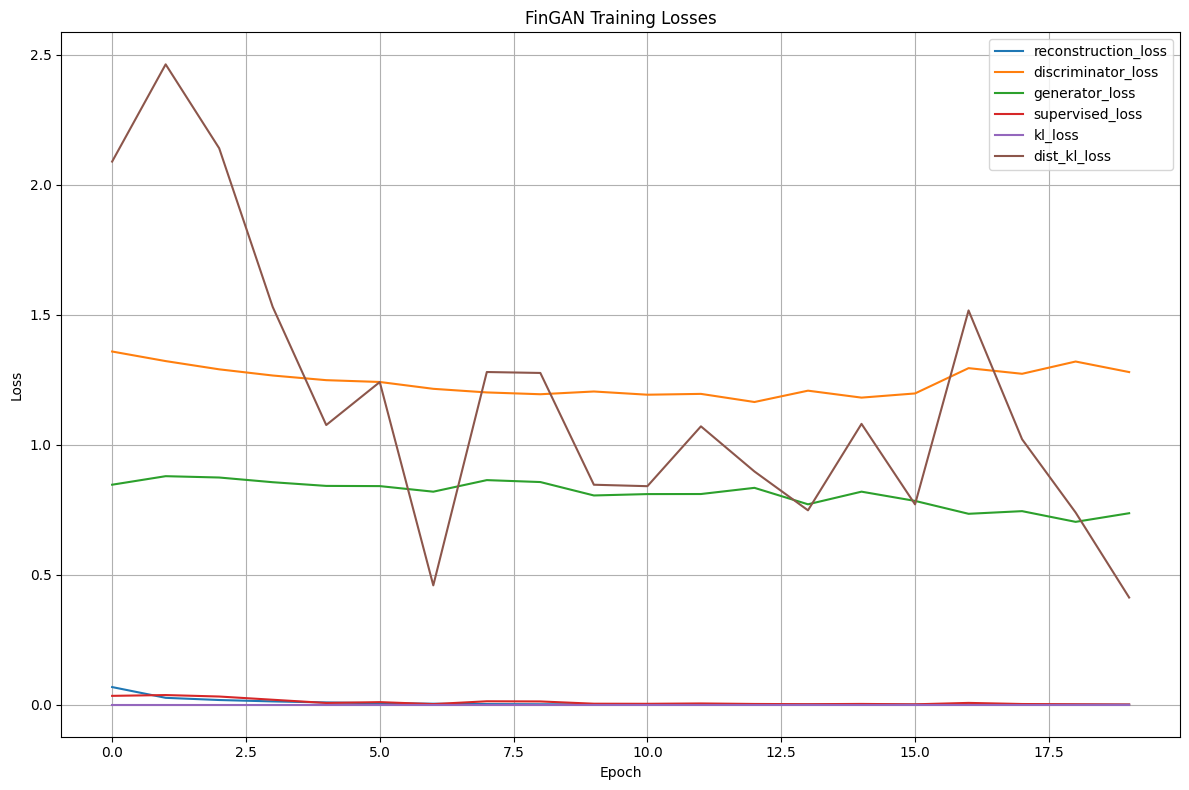


=== Evaluating FinGAN on Test Data ===
Pricing options with FinGAN model...
Processed 1374901/50 options
Processed 1374911/50 options
Processed 1374921/50 options
Processed 1374931/50 options
Processed 1374941/50 options

=== Calculating Performance Metrics ===

📊 **FinGAN Option Pricing Performance**
✅ **Mean Absolute Error (MAE):** 1005.0063
✅ **Root Mean Squared Error (RMSE):** 1134.4456
✅ **R² Score:** -1.4330

=== Visualizing Results ===


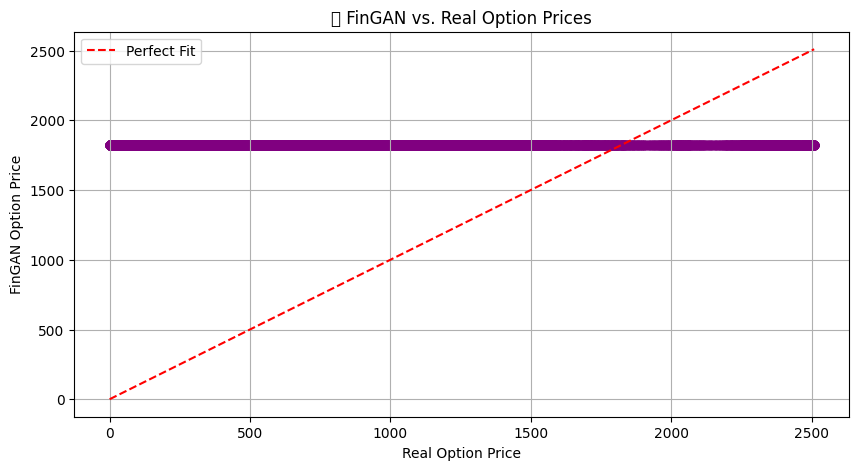


=== Generating Implied Volatility Surface ===


KeyboardInterrupt: 

In [10]:
print("\n=== Splitting Data ===")
# Split data: first year for training, second year for testing
option_data['Date'] = pd.to_datetime(option_data['Date'])
option_data['Days Since Start'] = (option_data['Date'] - option_data['Date'].min()).dt.days

train_data = option_data[option_data['Days Since Start'] < 365]
test_data = option_data[option_data['Days Since Start'] >= 365]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

print("\n=== Preparing Data for FinGAN ===")
# Prepare the stock return data for FinGAN training
receptive_field_size = 127  # Commonly used size for TCNs
stock_returns = prepare_option_data_for_fingan(stock_data, max_seq_len=receptive_field_size)
stock_returns_tensor = torch.tensor(stock_returns, dtype=torch.float32).to(device)

print(f"Prepared stock returns tensor with shape: {stock_returns_tensor.shape}")

print("\n=== Initializing FinGAN Model ===")
# Initialize and train the FinGAN model
hidden_dim = 80
noise_dim = 10
num_epochs = 100

# Create FinGAN
fingan = FinGAN(
    input_dim=1,
    hidden_dim=hidden_dim,
    noise_dim=noise_dim,
    rf_rate=0.05,  # Risk-free rate
    receptive_field_size=receptive_field_size,
    device=device
)

print("\n=== Training FinGAN Model ===")
# Train FinGAN on stock returns - use a reduced number of epochs for testing
num_epochs = 20  # Reduced for faster execution
fingan_losses = train_fingan(fingan, stock_returns_tensor, epochs=num_epochs, batch_size=1)

print("\n=== Visualizing Training Losses ===")
# Plot training losses
plt.figure(figsize=(12, 8))
for key, values in fingan_losses.items():
    # Filter out NaN values for plotting
    filtered_values = [v for v in values if not np.isnan(v)]
    epochs_filtered = list(range(len(filtered_values)))
    if filtered_values:  # Only plot if there are values
        plt.plot(epochs_filtered, filtered_values, label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FinGAN Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Evaluating FinGAN on Test Data ===")
# Generate FinGAN option prices for test data
test_results = pd.DataFrame()
test_results['Date'] = test_data['Date']
test_results['Stock Price'] = test_data['Stock Price']
test_results['Strike Price'] = test_data['Strike Price']
test_results['Time to Expiration'] = test_data['Time to Expiration']
test_results['Real Option Price'] = test_data['Option Price']
test_results['FinGAN Option Price'] = np.nan

print("Pricing options with FinGAN model...")

# Price options using FinGAN - limit to first 50 options for speed
sample_count = min(50, len(test_data))
for i, row in test_data.iloc[:sample_count].iterrows():
    try:
        S0 = row['Stock Price']
        K = row['Strike Price']
        T = row['Time to Expiration']
        r = 0.05  # Risk-free rate
        
        # Price option with FinGAN
        fingan_price = fingan.price_european_option(S0, K, T, r, option_type='call', n_paths=1000)
        test_results.loc[test_results['Date'] == row['Date'], 'FinGAN Option Price'] = fingan_price
        
        # Print progress
        if i % 10 == 0:
            print(f"Processed {i+1}/{sample_count} options")
    
    except Exception as e:
        print(f"Error pricing option: {e}")
        continue

print("\n=== Calculating Performance Metrics ===")
# Drop rows with missing FinGAN prices
test_results_valid = test_results.dropna(subset=['FinGAN Option Price'])

if len(test_results_valid) > 0:
    # Calculate performance metrics
    test_results_valid['Absolute Error'] = np.abs(test_results_valid['Real Option Price'] - test_results_valid['FinGAN Option Price'])
    test_results_valid['Relative Error (%)'] = 100 * test_results_valid['Absolute Error'] / test_results_valid['Real Option Price']
    
    mae = mean_absolute_error(test_results_valid['Real Option Price'], test_results_valid['FinGAN Option Price'])
    rmse = np.sqrt(mean_squared_error(test_results_valid['Real Option Price'], test_results_valid['FinGAN Option Price']))
    r2 = r2_score(test_results_valid['Real Option Price'], test_results_valid['FinGAN Option Price'])
    
    print("\n📊 **FinGAN Option Pricing Performance**")
    print(f"✅ **Mean Absolute Error (MAE):** {mae:.4f}")
    print(f"✅ **Root Mean Squared Error (RMSE):** {rmse:.4f}")
    print(f"✅ **R² Score:** {r2:.4f}")
    
    print("\n=== Visualizing Results ===")
    # 🎯 Scatter Plot: Real vs. Generated Option Prices
    plt.figure(figsize=(10, 5))
    plt.scatter(test_results_valid['Real Option Price'], test_results_valid['FinGAN Option Price'], alpha=0.7, color="purple")
    plt.plot([min(test_results_valid['Real Option Price']), max(test_results_valid['Real Option Price'])], 
                [min(test_results_valid['Real Option Price']), max(test_results_valid['Real Option Price'])], 
                'r--', label='Perfect Fit')
    plt.xlabel("Real Option Price")
    plt.ylabel("FinGAN Option Price")
    plt.title("🔍 FinGAN vs. Real Option Prices")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid FinGAN option prices were generated.")

print("\n=== Generating Implied Volatility Surface ===")
try:
    # Generate and visualize an implied volatility surface
    maturities = [0.05, 0.1, 0.2, 0.3, 0.5]  # In years
    moneyness_levels = [0.8, 0.9, 1.0, 1.1, 1.2]  # K/S0
    
    # Generate implied volatility surface
    iv_surface = fingan.generate_implied_volatility_surface(100, 0.05, maturities, moneyness_levels)
    
    # Plot implied volatility surface
    X, Y = np.meshgrid(moneyness_levels, maturities)
    
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, iv_surface, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Moneyness (K/S0)')
    ax.set_ylabel('Time to Maturity (Years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface Generated by FinGAN')
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating implied volatility surface: {e}")

except Exception as e:
    print(f"Critical error in main script: {e}")


=== Visualizing Option Prices Over Time ===


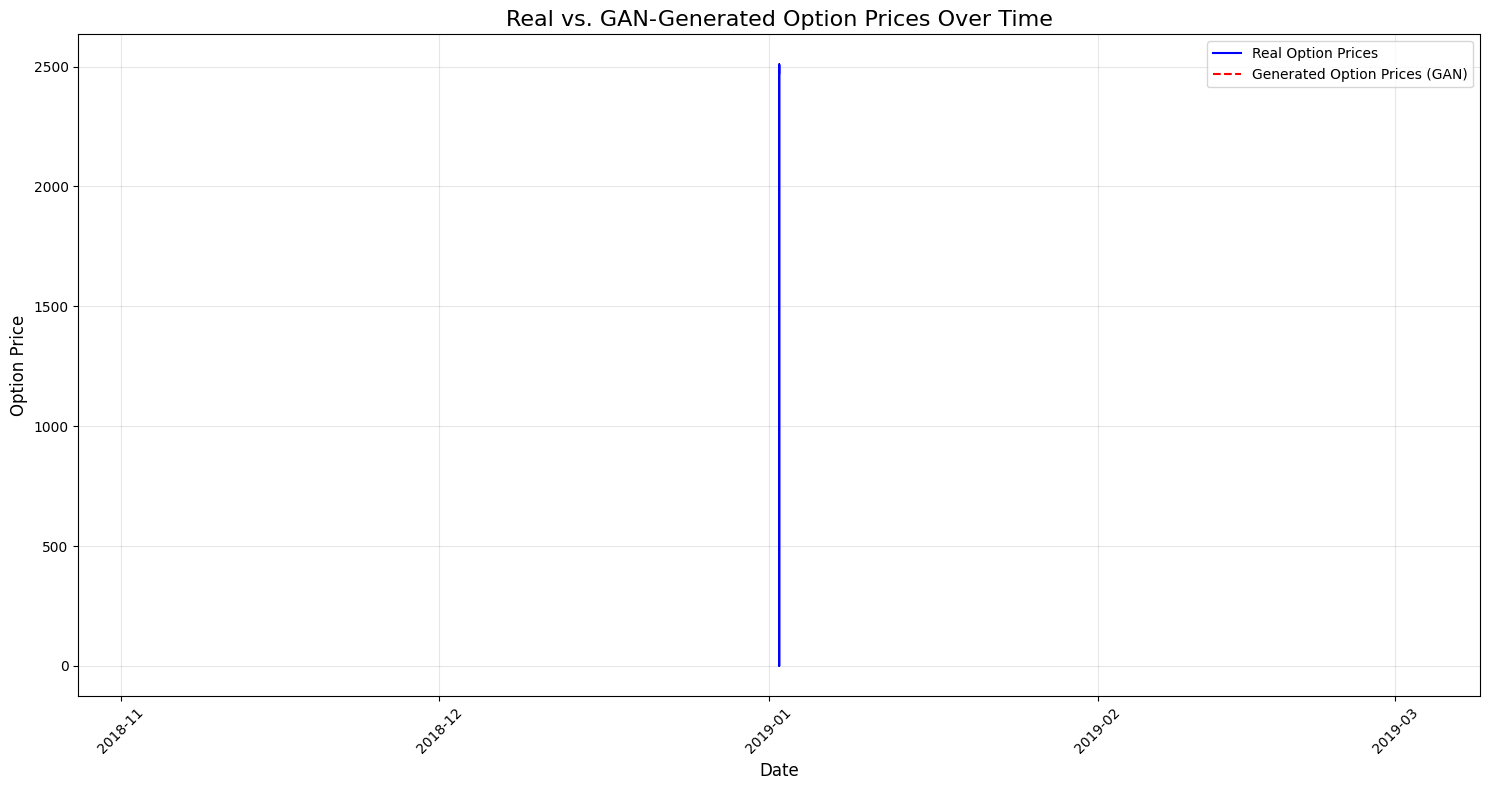

In [11]:
# Add this to a separate cell for independent visualization

def visualize_option_prices_over_time(test_data, fingan_prices):
    """
    Visualize real vs GAN-generated option prices over time
    
    Args:
        test_data: DataFrame containing real option data
        fingan_prices: Series or array of FinGAN-generated option prices
    """
    # Prepare data
    viz_data = test_data[['Date', 'Real Option Price']].copy()
    
    # Make sure the dates are datetime objects
    viz_data['Date'] = pd.to_datetime(viz_data['Date'])
    
    # Add FinGAN generated prices
    viz_data['Generated Option Price (GAN)'] = fingan_prices
    
    # Remove any rows with NaN values
    viz_data = viz_data.dropna()
    
    # Sort by date
    viz_data = viz_data.sort_values('Date')
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot real option prices
    plt.plot(viz_data['Date'], viz_data['Real Option Price'], 
             label='Real Option Prices', color='blue', linewidth=1.5)
    
    # Plot GAN-generated option prices
    plt.plot(viz_data['Date'], viz_data['Generated Option Price (GAN)'], 
             label='Generated Option Prices (GAN)', color='red', linestyle='--', linewidth=1.5)
    
    # Set labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    plt.title('Real vs. GAN-Generated Option Prices Over Time', fontsize=16)
    
    # Format the date axis
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add legend
    plt.legend(fontsize=10)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Check if we have test_results_valid defined and it contains data
if 'test_results_valid' in locals() and len(test_results_valid) > 0:
    print("\n=== Visualizing Option Prices Over Time ===")
    
    # Create a visualization of option prices over time
    visualize_option_prices_over_time(
        test_results_valid, 
        test_results_valid['FinGAN Option Price']
    )
else:
    # If test_results_valid is not defined or doesn't have data, can run this for a quick example
    print("No valid test data found. Create sample data for demonstration.")
    
    # Create sample data for demonstration
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime
    
    # Generate sample dates
    dates = pd.date_range(start='2023-01-01', periods=100)
    
    # Generate sample prices
    real_prices = np.sin(np.linspace(0, 10, 100)) * 5 + 10 + np.random.normal(0, 0.5, 100)
    gan_prices = real_prices + np.random.normal(0, 1, 100)
    
    # Create sample dataframe
    sample_data = pd.DataFrame({
        'Date': dates,
        'Real Option Price': real_prices
    })
    
    # Visualize sample data
    visualize_option_prices_over_time(sample_data, gan_prices)